<center>
  <h1>ST7: Modélisation Des Risques Financiers</h1>
  <h2>TD1: Base de données et premier back-test</h2>
</center>



## Exercice 1. *Python Library*

Installer : *cvxpy, pandas, numpy, yfinance*

In [1]:
import cvxpy as cp
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

## Exercice 2. *US equity Index*

Nous allons reconstruire un indice boursier repésentatif du marché des actions américaines. Pour vous aider, vous disposez d’un fichier Excel contenant une partie de l’information.
1. « Mapping », vous avez une correspondance entre les sedol 1 et le ticker à utiliser pour télécharger les données de prix à partir de la librarie *yfinance*
2. « MarketCaps », vous avez le poids de chaque entreprise composant votre indice pour tous les mois i.e. l’entreprise 200001 a un poids de 0.0016352 pour tout le mois de décembre 2005. Cette entreprise n’est pas dans votre indice avant cette date et elle a un poids de 0.0016 pour tout le mois de janvier 2006. Ce poids correspond à la Market Cap : « la capitalisation boursière est la valorisation au prix de marché de l’ensemble des actions en circulation d’une société par actions. ».
3. « Sector », vous avez une clé pour chaque entreprise et son secteur d’appartenance.

In [2]:
# Get the data
Mappings = pd.read_excel('DataProjects.xlsx', sheet_name='Mapping')
MarketCaps = pd.read_excel('DataProjects.xlsx', sheet_name='MarketCaps')
Sector = pd.read_excel('DataProjects.xlsx', sheet_name='Sector')

print(Mappings)
print(MarketCaps)
print(Sector)

      Sedol Tickers  Unnamed: 2  Unnamed: 3              Unnamed: 4
0    200001    AMZN         NaN         NaN                     NaN
1    200247     AES         NaN         4.0  CONSUMER DISCRETIONARY
2    200597     IBM         NaN         5.0        CONSUMER STAPLES
3    200784     AMD         NaN         6.0                  ENERGY
4    200815    ADBE         NaN         7.0              FINANCIALS
..      ...     ...         ...         ...                     ...
556  BK73B4    CTVA         NaN         NaN                     NaN
557  BJ1F30    AMCR         NaN         NaN                     NaN
558  BK4N0D    CARR         NaN         NaN                     NaN
559  BK531S    OTIS         NaN         NaN                     NaN
560  BMWS3X    VTRS         NaN         NaN                     NaN

[561 rows x 5 columns]
    Unnamed: 0    200001    200247    200597    200784    200815    201160   
0   2002-12-31  0.000000  0.000304  0.021304  0.000290  0.001006  0.001518  \
1   

Pour chaque entreprise i, on définit la performance quotidienne par $r_t^i = \frac{P_t^i}{P_{t-1}^i} − 1$. La performance quotidienne de notre indice américain : $r_t^{S\&P300} = \sum_{i=1}^{N} \omega_t^i ∗ r_t^i$ avec $\omega$ constant pendant le mois pour l’entreprise $i$ et dans notre cas $N = 300$.

### a. Téléchargez les données quotidiennes en utilisant yfinance et les tickers fournis.

In [3]:
# Download the data using yfinance and ticker symbols
tickers = Mappings['Tickers'].tolist()
data = yf.download(tickers, start="2002-12-31", end="2024-01-31")

print(data.head())

[*********************100%***********************]  561 of 561 completed

50 Failed downloads:
- SHLDQ: No timezone found, symbol may be delisted
- MDP: No timezone found, symbol may be delisted
- ABMD: No data found, symbol may be delisted
- NLOK: No timezone found, symbol may be delisted
- WYND: No timezone found, symbol may be delisted
- CTXS: No timezone found, symbol may be delisted
- BBBY: No timezone found, symbol may be delisted
- VALPQ: No timezone found, symbol may be delisted
- PEAK: No data found, symbol may be delisted
- CHKAQ: No timezone found, symbol may be delisted
- DISCA: No timezone found, symbol may be delisted
- ENDP: Period 'max' is invalid, must be one of ['1d', '5d']
- BLL: No timezone found, symbol may be delisted
- FLIR: No timezone found, symbol may be delisted
- XEC: No timezone found, symbol may be delisted
- ATVI: No timezone found, symbol may be delisted
- PXD: No data found, symbol may be delisted
- KSU: No timezone found, symbol may be delisted
- FLT: 

### b. Stockez les données (en lignes les dates et en colonne les entreprises) dans dataframe python (fonc- tions ou méthodes merge, concat ou join pour assembler vos données).

Déjà fait dans *data*.

Exemple avec IBM

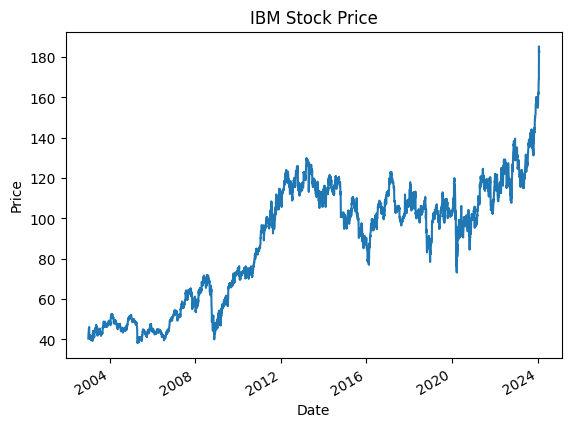

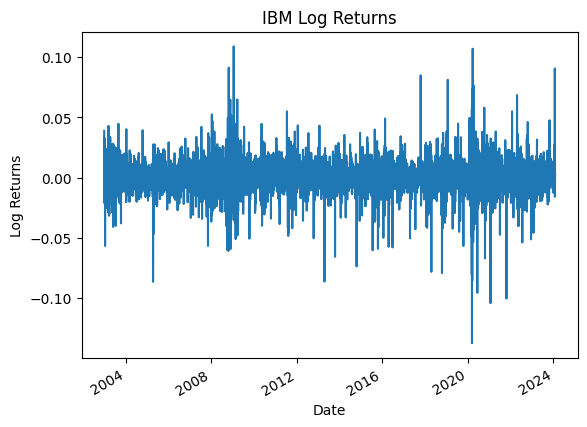

In [4]:
# Extract the price of IBM (IBM)
IBM = data['Adj Close']['IBM'] # Take either Adj Close or Close. Adj Close is adjusted for dividends and stock splits, it's often used for historical data.

# Plot the graph of the price of IBM
IBM.plot(kind='line', title='IBM Stock Price', xlabel='Date', ylabel='Price')
plt.show()

# Plot log returns of IBM
log_returns = np.log(IBM/IBM.shift(1))
log_returns.plot(title='IBM Log Returns', xlabel='Date', ylabel='Log Returns')
plt.show()

### c. Nettoyez votre base i.e. lorsqu’un prix est manquant une journée, il faut le remplacer par le prix du jour précédent quand cela est possible. Il faut laisser le prix absent si l’entreprise n’a jamais diffusé de prix ou si elle a fait faillite.

In [5]:
# Replace NaN for only one month by the price of the previous month
print('Before:' + str(data.isna().sum().sum()))
data_filled = data.fillna(method='ffill') # The ffill method fills the NaN with the value of the previous month
print('After:' + str(data_filled.isna().sum().sum()))

Before:2792100
After:2629320


### d. Reconstituez votre indice boursier américain avec des données quotidiennes et un rebalancement mensuelle (i.e. vous changez les entreprises constituant votre indice tous les mois) $\omega_t^{i+1} = \omega_t^i$ quand $t$ et $t + 1$ sont dans le même mois i.e. Jan. 2015. Les differents $\omega_t^i$ sont publiés en fin de mois. Verifier que, pour tous les mois, vous avez bien une somme de poids $\sum_{i=1}^N \omega_t^i = 1$ et que vous avez bien un rendement pour chaque entreprise pendans tous les jours (voir Nettoyez votre base). S’il vous manque un rendement, apres nettoyage, une entreprise ou deux, vous pouvez reduire $N^{∗} = 299*$ ou $N^{∗} = 298$ mais il faut ajuster de façon linéaire les $\omega_t^i$ pour obtenir $\sum_{i=1}^N \omega_t^i = 1$.

Corresponding map:{200001: 'AMZN', 200247: 'AES', 200597: 'IBM', 200784: 'AMD', 200815: 'ADBE', 201160: 'APD', 201947: 'BXP', 201995: 'ALL', 202045: 'HON', 'BYNF41': 'AA', 202360: 'AMGN', 202374: 'HES', 202608: 'AXP', 202624: 'AEP', 202636: 'AFL', 202734: 'AIG', 203206: 'ADI', 203607: 'ALXN', 204136: 'VLO', 204396: 'APA', 204454: 'CMCSA', 204625: 'AAPL', 204655: 'AMAT', 204731: 'ADM', 204880: 'PNW', 205083: 'AEE', 206515: 'ADSK', 206530: 'ADP', 206595: 'AZO', 206892: 'BMC', 'BDHLTQ': 'BKR', 207302: 'BLL', 207340: 'CEG', 208510: 'BAX', 208587: 'BBBY', 208780: 'BDX', 208921: 'AME', 209057: 'VZ', 209467: 'BBY', 209887: 'YUM', 210092: 'FE', 210196: 'SLM', 210550: 'HRB', 210860: 'BA', 211070: 'RHI', 211195: 'BWA', 211343: 'BSX', 211622: 'CHRW', 212633: 'BMY', 213010: 'OKE', 213117: 'AVB', 213815: 'SRE', 214278: 'FDX', 214292: 'VRSN', 214508: 'APH', 215020: 'PWR', 216075: 'CSX', 216234: 'COG', 216284: 'CPB', 217047: 'STZ', 217567: 'CAH', 218020: 'CAT', 218255: 'CTXS', 'BLK8HG': 'CHKAQ', 2185

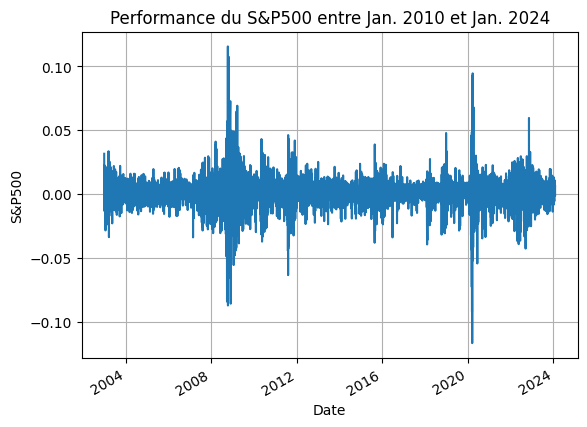

In [6]:
# Compute the daily returns
returns = data_filled.pct_change()['Adj Close']
returns = returns.drop(returns.index[0]) # The first row contains NaN, so we drop it. Also, since we are using daily returns, we don't need the first row.

# Put the first column of MarketCaps as the index
MarketCaps = pd.read_excel('DataProjects.xlsx', sheet_name='MarketCaps', index_col=0)

# Obtain Mappings
Mappings = pd.read_excel('DataProjects.xlsx', sheet_name='Mapping')

# Drop the three last columns after observing the data
Mappings = Mappings.iloc[:, :-3]

# Create a map to match the tickers with the sedol
tickers = Mappings['Tickers'].tolist()
sedols = Mappings['Sedol'].tolist()
map = dict(zip(sedols, tickers))
print('Corresponding map:' + str(map) + '\n')

# Replace the name of the columns of MarketCaps by the tickers
MarketCaps.columns = tickers

# Keep only the month and the year of the index
MarketCaps.index = MarketCaps.index.to_period('M')
print('New index of MarketCaps:' + str(MarketCaps.index))

# Adding one month to the index since the weight is used for the next month
MarketCaps.index = MarketCaps.index + 1

# Replace all NaN by 0 (not necessary, but it's better, we don't know what can happen)
MarketCaps = MarketCaps.fillna(0)

# Normalize the MarketCaps to make the sum of each row equal to 1
MarketCaps = MarketCaps.div(MarketCaps.sum(axis=1), axis=0)

# Transforming Index of returns to DatetimeIndex
returns.index = pd.to_datetime(returns.index)

# Keeping the dates with the days before doing the merge
old_dates = returns.index

# Keep only the year and the month
returns.index = returns.index.to_period('M')

# Merge the returns and the MarketCaps 
df = returns.merge(MarketCaps, left_index=True, right_index=True) # This is useful to have every returns associated to the market caps of the same month

# Replace the index of df by the old dates
df.index = old_dates

# Drop all the _x columns
df = df.loc[:, ~df.columns.str.endswith('_x')]

# Delethe the _y at the end of the columns
df.columns = df.columns.str.rstrip('_y')

# Change the name of the index of returns to before
returns.index = old_dates

# Multiply the returns by df
result = df.mul(returns) # To do this, the two tables must have the same index and the same columns

# Compute the sum of the columns
result['Snp500'] = result.sum(axis=1)

# Compute the cumsum of Snp500
result['Snp500'] = result['Snp500']

# Plot the Snp500 with a dashed grid
result['Snp500'].plot(title='Performance du S&P500 entre Jan. 2010 et Jan. 2024', xlabel='Date', ylabel='S&P500', grid=True)
plt.show()

### e. Tracez l’indice obtenu avec une premiere date = 100 
$P_0 = 1$ <br>
$P_1 = P_0 * (1 + r_1^{S\&P300})$ <br>
$P_t = P_{t-1} * (1 + r_{t-1}^{S\&P300})$

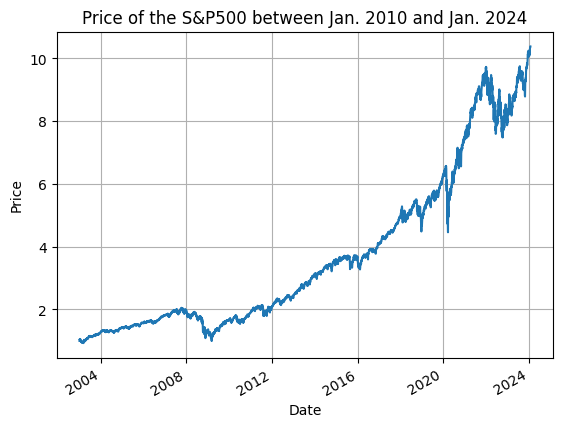

In [7]:
# Compute th price of the S&P500 starting with 1
N = len(result['Snp500']) - 1

# Create a vector of 0s
result['Price'] = np.zeros(len(result['Snp500']))

# Compute the price of the S&P500
result['Price'][0] = 1
for i in range(1, N):
    result['Price'][i] = result['Price'][i-1] * (1 + result['Snp500'][i - 1])

# Plot the price of the S&P500
result['Price'][:N].plot(title='Price of the S&P500 between Jan. 2010 and Jan. 2024', xlabel='Date', ylabel='Price', grid=True)
plt.show()


### f. Mettez en place une méthode pour stocker ces données ou une routine pour retélécharger les données à chaque TP !


In [8]:
# Save the data in a new Numpy file called 'result.npy'
result.to_csv('results/result.csv')
data.to_csv('results/data.csv')
MarketCaps.to_csv('results/MarketCaps.csv')
returns.to_csv('results/returns.csv')

## Exercice 4. *Sectors*

Quels risques pour les différents secteurs. $\beta_{\text {Energy }}=\frac{\operatorname{Cov}\left(r_{E n e r g y} r_{S \& P 300}\right)}{\operatorname{Var}\left(r_{S \& P 300}\right)}$. La « tracking error » ou l'erreur de réplication est une mesure de risque utilisée en gestion d'actifs dans les portefeuilles indiciels ou se comparant à un indice de référence $\sigma_{\text {trackingerror }}^{\text {energy }}=\sqrt{\frac{1}{N} \sum_{t=1}^N\left(r_t^{\text {energy }}-r_t^{S \& P 300}\right)^2}$.

### a. Reconstituez la performance des différents secteurs en rebasant les poids à 100% par secteur pour reconstuire les différents indices sectoriels.

In [13]:
### Not finished in this td, but foundable in markowitz.ipynb

WANTED_SECTOR = 4

# Define the map of the sectors
sectors_map = {4: 'CONSUMER DISCRETIONARY', 5: 'CONSUMER STAPLES', 6: 'ENERGY', 7: 'FINANCIALS', 8: 'HEALTH CARE', 9: 'INDUSTRIALS', 10: 'INFORMATION TECHNOLOGY', 11: 'MATERIALS', 14: 'UTILITIES'}

MarketCaps = pd.read_csv('results/MarketCaps.csv', index_col=0)
returns = pd.read_csv('results/returns.csv', index_col=0)

# Import Sectors
Sector = pd.read_excel('DataProjects.xlsx', sheet_name='Sector', index_col=0)

# Fill values by the previous value
Sector = Sector.fillna(method='ffill')

different_sectors = Sector.stack().unique()

# Compute the number of different sectors and print their numbers
print('Different sectors: ', Sector.stack().unique())

# DateTime the index of Sector
Sector.index = pd.to_datetime(Sector.index)

# Keep only the year and the month
Sector.index = Sector.index.to_period('M')

# Adding one month to the index since the weight is used for the next month
Sector.index = Sector.index + 1

# Obtain Mappings
Mappings = pd.read_excel('DataProjects.xlsx', sheet_name='Mapping')

# Drop the three last columns after observing the data
Mappings = Mappings.iloc[:, :-3]

# Create a map to match the tickers with the sedol
tickers = Mappings['Tickers'].tolist()
sedols = Mappings['Sedol'].tolist()
map = dict(zip(sedols, tickers))

# Applying map to the columns of Sector
Sector.columns = Sector.columns.map(map)


# For each month, sum the market caps of the companies in the same sector
MarketCaps_sectors = {}
SnP500_sectors = {}

for date in MarketCaps.index:
    for index in sectors_map.keys():
        Sector_index = (Sector.loc[date] == index).astype(int)
        MarketCaps_sectors[index] = MarketCaps.loc[date].mul(Sector_index)
        # The sum on each row must be equal to 1
        MarketCaps_sectors[index] = MarketCaps_sectors[index].div(MarketCaps_sectors[index].sum(), axis=0)
        returns_sector = returns.loc[date]
        df_sector = returns_sector.merge(MarketCaps_sectors[index], left_index=True, right_index=True)
        df_sector = df_sector.loc[:, ~df_sector.columns.str.endswith('_x')]
        df_sector.columns = df_sector.columns.str.rstrip('_y')
        result_sector = df_sector.mul(returns_sector)
        result_sector['Snp500'] = result_sector.sum()
        result_sector['Snp500'] = result_sector['Snp500']
        SnP500_sectors[index] = result_sector['Snp500']

for index in sectors_map.keys():
    Sector_index = (Sector.copy() == index).astype(int)
    MarketCaps_sectors[index] = MarketCaps.copy().mul(Sector_index)
    # The sum on each row must be equal to 1
    MarketCaps_sectors[index] = MarketCaps_sectors[index].div(MarketCaps_sectors[index].sum(axis=1), axis=0)
    returns_sector = returns.copy()
    returns_sector.index = pd.to_datetime(returns_sector.index)
    returns_sector.index = returns_sector.index.to_period('M')
    df_sector = returns_sector.merge(MarketCaps_sectors[index], left_index=True, right_index=True)
    df_sector.index = old_dates
    df_sector = df_sector.loc[:, ~df_sector.columns.str.endswith('_x')]
    df_sector.columns = df_sector.columns.str.rstrip('_y')
    returns_sector.index = old_dates
    result_sector = df_sector.mul(returns_sector)
    result_sector['Snp500'] = result_sector.sum(axis=1)
    result_sector['Snp500'] = result_sector['Snp500']
    SnP500_sectors[index] = result_sector['Snp500']
    SnP500_sectors[index].index = pd.to_datetime(SnP500_sectors[index].index)


old_dates = returns.index

MarketCaps.index = Sector.index
MarketCaps.columns = Sector.columns

MarketCaps_sectors = {}
SnP500_sectors = {}

for index in sectors_map.keys():
    Sector_index = (Sector.copy() == index).astype(int)
    MarketCaps_sectors[index] = MarketCaps.copy().mul(Sector_index)
    # The sum on each row must be equal to 1
    MarketCaps_sectors[index] = MarketCaps_sectors[index].div(MarketCaps_sectors[index].sum(axis=1), axis=0)
    returns_sector = returns.copy()
    returns_sector.index = pd.to_datetime(returns_sector.index)
    returns_sector.index = returns_sector.index.to_period('M')
    df_sector = returns_sector.merge(MarketCaps_sectors[index], left_index=True, right_index=True)
    df_sector.index = old_dates
    df_sector = df_sector.loc[:, ~df_sector.columns.str.endswith('_x')]
    df_sector.columns = df_sector.columns.str.rstrip('_y')
    returns_sector.index = old_dates
    result_sector = df_sector.mul(returns_sector)
    result_sector['Snp500'] = result_sector.sum(axis=1)
    result_sector['Snp500'] = result_sector['Snp500']
    SnP500_sectors[index] = result_sector['Snp500']
    SnP500_sectors[index].index = pd.to_datetime(SnP500_sectors[index].index)

N = len(SnP500_sectors[4]) - 1

price_sectors = {}

for index in sectors_map.keys():
    price_sectors[index] = SnP500_sectors[index].copy()
    price_sectors[index][:] = 0
    price_sectors[index][0] = 1
    for i in range(1, N):
        price_sectors[index][i] = price_sectors[index][i-1] * (1 + SnP500_sectors[index][i - 1])
    price_sectors[index][:N].plot(title='Price of the S&P500 for the sector ' + str(sectors_map[index]), xlabel='Date', ylabel='Price', grid=True)
    plt.show()

# Plot the price of the S&P500 with all the sectors in the same graph
for index in sectors_map.keys():
    plt.plot(price_sectors[index][:N], label=sectors_map[index])
plt.title('Price of the S&P500 for all sectors')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Different sectors:  [ 4. 14. 10. 11.  7.  9.  8.  6.  5.]


KeyError: '2003-01'